# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from train_test.load_train import *
from train_test.load_test import *

In [3]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json
from collections import deque

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

import seaborn as sns

In [4]:
from dataloaders import dataset_ST_MultiPoint
# from dataloaders import load_dataset
# from loss import losses_SparseData
# from models import models_SparseData
# from optimizer import load_optimizer

from subprocess import Popen

# Load dictionary

In [5]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/CPoint_Sparse/CPoint_Sparse_Transformer_0.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_Transformer', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'ST_MultiPoint', 'piezo_head': True, 'relative_target': False, 'target_lags': [1, 2], 'nan_treshold': 10, 'fill_value': 0, 'normal

# Dataset class

In [6]:
importlib.reload(dataset_ST_MultiPoint)

<module 'dataloaders.dataset_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_ST_MultiPoint.py'>

In [7]:
ds = dataset_ST_MultiPoint.Dataset_ST_MultiPoint(dict_files)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_means': np.float64(298.19569411165224), 'target_stds': np.float64(73.65282819016454), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.602
    tmax         float32 4B 12.35
    tmin         float32 4B 5.037
    tmean        float32 4B 8.694, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    s

In [8]:
ds.wtd_df

wtd       lat       lon    height         h  \
date       sensor_id                                                        
2000-12-31 00103510001        NaN  0.053733 -0.154105 -0.866947       NaN   
           00104110001        NaN  0.202696  0.094087 -0.951262       NaN   
           00105110001        NaN  0.446357  0.518426 -1.021212       NaN   
           00105910001        NaN  0.149836  0.808310 -1.018794       NaN   
           00105910002        NaN  0.233721  0.722698 -1.028230       NaN   
...                           ...       ...       ...       ...       ...   
2023-12-24 00417910001   5.068571 -0.123456  0.725215 -0.997253 -0.626484   
           00421510001   3.931905 -0.516018  0.642913 -0.929923  0.197800   
           00421710001   6.553762 -0.380864  0.446580 -0.962027 -0.223473   
           00422510001  26.085667 -0.911923  0.364473 -0.777247  1.731121   
           00425010001   4.953333 -0.751001  0.463569 -0.852743  1.111101   

                             doy_sin   doy_cos  
date       sensor_id                            
2000-12-31 00103510001 -2.449294e-16  1.000000  
           00104110001 -2.449294e-16  1.000000  
           00105110001 -2.449294e-16  1.000000  
           00105910001 -2.449294e-16  1.000000  
           00105910002 -2.449294e-16  1.000000  
...                              ...       ...  
2023-12-24 00417910001 -1.369061e-01  0.990584  
           00421510001 -1.369061e-01  0.990584  
           00421710001 -1.369061e-01  0.990584  
           00422510001 -1.369061e-01  0.990584  
           00425010001 -1.369061e-01  0.990584  

[33600 rows x 7 columns]

In [9]:
ds.lagged_df

h       lat       lon    height   doy_sin  \
date       sensor_id                                                       
2001-03-04 00103510001  0.689230  0.053733 -0.154105 -0.866947  0.882679   
           00104110001       NaN  0.202696  0.094087 -0.951262  0.882679   
           00105110001       NaN  0.446357  0.518426 -1.021212  0.882679   
           00105910001 -0.898284  0.149836  0.808310 -1.018794  0.882679   
           00105910002       NaN  0.233721  0.722698 -1.028230  0.882679   
...                          ...       ...       ...       ...       ...   
2023-12-24 00417910001 -0.626484 -0.123456  0.725215 -0.997253 -0.136906   
           00421510001  0.197800 -0.516018  0.642913 -0.929923 -0.136906   
           00421710001 -0.223473 -0.380864  0.446580 -0.962027 -0.136906   
           00422510001  1.731121 -0.911923  0.364473 -0.777247 -0.136906   
           00425010001  1.111101 -0.751001  0.463569 -0.852743 -0.136906   

                         doy_cos  doy_sin_lag1  doy_cos_lag1  \
date       sensor_id                                           
2001-03-04 00103510001  0.469977      0.819972      0.572404   
           00104110001  0.469977      0.819972      0.572404   
           00105110001  0.469977      0.819972      0.572404   
           00105910001  0.469977      0.819972      0.572404   
           00105910002  0.469977      0.819972      0.572404   
...                          ...           ...           ...   
2023-12-24 00417910001  0.990584     -0.254671      0.967028   
           00421510001  0.990584     -0.254671      0.967028   
           00421710001  0.990584     -0.254671      0.967028   
           00422510001  0.990584     -0.254671      0.967028   
           00425010001  0.990584     -0.254671      0.967028   

                        00103510001_lag1  00104110001_lag1  ...  \
date       sensor_id                                        ...   
2001-03-04 00103510001          0.691232               NaN  ...   
           00104110001          0.691232               NaN  ...   
           00105110001          0.691232               NaN  ...   
           00105910001          0.691232               NaN  ...   
           00105910002          0.691232               NaN  ...   
...                                  ...               ...  ...   
2023-12-24 00417910001          0.662022         -0.340009  ...   
           00421510001          0.662022         -0.340009  ...   
           00421710001          0.662022         -0.340009  ...   
           00422510001          0.662022         -0.340009  ...   
           00425010001          0.662022         -0.340009  ...   

                        00407810001_lag2  00408910001_lag2  00408910002_lag2  \
date       sensor_id                                                           
2001-03-04 00103510001          2.425338          0.723081               NaN   
           00104110001          2.425338          0.723081               NaN   
           00105110001          2.425338          0.723081               NaN   
           00105910001          2.425338          0.723081               NaN   
           00105910002          2.425338          0.723081               NaN   
...                                  ...               ...               ...   
2023-12-24 00417910001          2.399884               NaN          1.354466   
           00421510001          2.399884               NaN          1.354466   
           00421710001          2.399884               NaN          1.354466   
           00422510001          2.399884               NaN          1.354466   
           00425010001          2.399884               NaN          1.354466   

                        00414310002_lag2  00417910001_lag2  00421510001_lag2  \
date       sensor_id                                                           
2001-03-04 00103510001               NaN         -0.617409          0.201254   
           00104110001               NaN         -0.6174

In [123]:
ds.norm_factors["lat_mean"]

np.float64(44.8125)

In [10]:
ds.wtd_geodf

,sensor_id,wb_id,loc_name,munic,loc,sart_date,end_date,gw_type,geometry,height,lon,lat
0,00103510001,GWB-S5b,P45 Bricherasio,Bricherasio,Piazzale cimitero,2009-01-01,None,Shallow,POINT (7.3085 44.82984),372.416901,7.308503,44.829842
1,00104110001,GWB-S5a,P24 Buriasco,Buriasco,davanti cimitero,2009-01-01,None,Shallow,POINT (7.4156 44.87792),297.815430,7.415599,44.877920
2,00105110001,GWB-S3b,P20 Candiolo,Candiolo,davanti cimitero,2009-01-01,None,Shallow,POINT (7.5987 44.95656),235.923615,7.598704,44.956561
3,00105910001,GWB-S4b,P16 Carmagnola,Carmagnola,"Peso pubblico, P.za della Concordia",2009-01-01,None,Shallow,POINT (7.72379 44.86086),238.062408,7.723791,44.860859
4,00105910002,GWB-S5a,TF2 Tetto Frati Carmagnola,Carmagnola,C/o Centro Sperimentale della FacoltÃ di Agraria,2009-01-01,None,Shallow,POINT (7.68685 44.88793),229.713989,7.686849,44.887933
5,00107010001,GWB-S5b,P15 Cavour,Cavour,lato cimitero,2009-01-01,None,Shallow,POINT (7.38103 44.78737),297.513123,7.381028,44.787368
6,00109010001,GWB-S3b,P18 Collegno,Collegno,su strada in via della Piombia,2009-01-01,None,Shallow,POINT (7.57467 45.0939),291.650299,7.574672,45.093902
7,00112710001,GWB-S5a,P19 La Loggia,La Loggia,"Zona industriale, parcheggio Via D. Vittorio",2009-01-01,None,Shallow,POINT (7.67314 44.963),223.828842,7.673142,44.963005
8,00117110001,GWB-S3b,P10 Orbassano,Orbassano,piazzale campo sportivo,2009-01-01,None,Shallow,POINT (7.53446 45.0163),272.287170,7.534463,45.016302
9,00119710001,GWB-S4a,P22 Poirino,Poirino,"Parcheggio cimitero comunale, V.le delle Rimem...",2009-01-01,None,Shallow,POINT (7.84773 44.92544),238.712112,7.847733,44.925444


In [11]:
(pd.Series(ds.dates).diff().dropna() == pd.Timedelta('1W')).all()

np.True_

In [12]:
ds.weather_coords.shape

(9, 12, 3)

In [13]:
# X [values, coords, mask]
print(ds[-1][0][0].shape)
print(ds[-1][0][1].shape)
print(ds[-1][0][2].shape)

torch.Size([2, 28])
torch.Size([2, 28, 5])
torch.Size([2, 28])


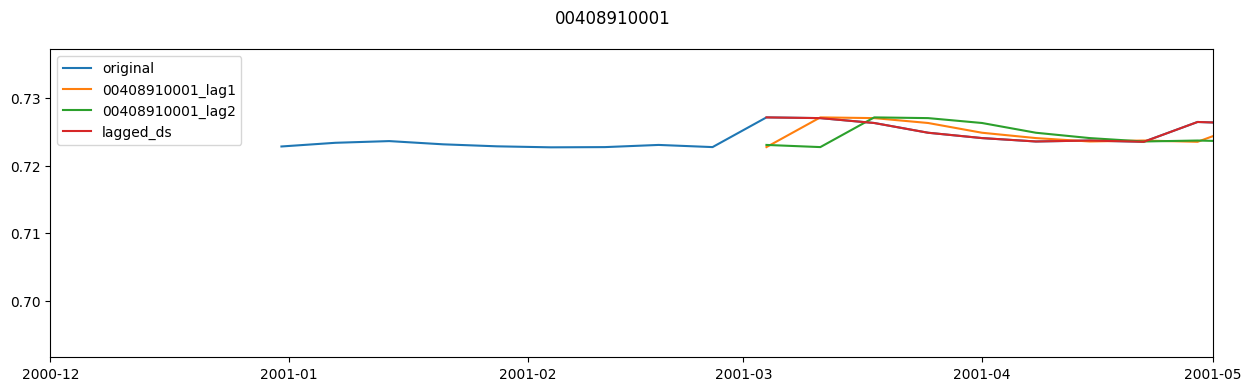

In [14]:
# Test
sensor = -8
fig, ax = plt.subplots(figsize = (15,4))
sensor_id = ds.sensor_id_list[sensor]
sensor_lag_names = [name for name in ds.lagged_df.columns if sensor_id in name]

fig.suptitle(sensor_id)

ax.plot(ds.wtd_df.loc[pd.IndexSlice[:,sensor_id],
                      ds.target].droplevel(1), label = "original")


for i in range(len(ds.target_lags)):
    
    ax.plot(ds.lagged_df.loc[pd.IndexSlice[:,sensor_id],
                      sensor_lag_names[i]].droplevel(1), label = sensor_lag_names[i])    
    
ax.plot(ds.lagged_df.loc[pd.IndexSlice[:,sensor_id],
                      ds.target].droplevel(1), label = "lagged_ds")
ax.legend()
ax.set_xlim(np.datetime64("2000-12-01"),
            np.datetime64("2001-05-01"))
    
plt.show()

<Axes: xlabel='wtd', ylabel='Count'>

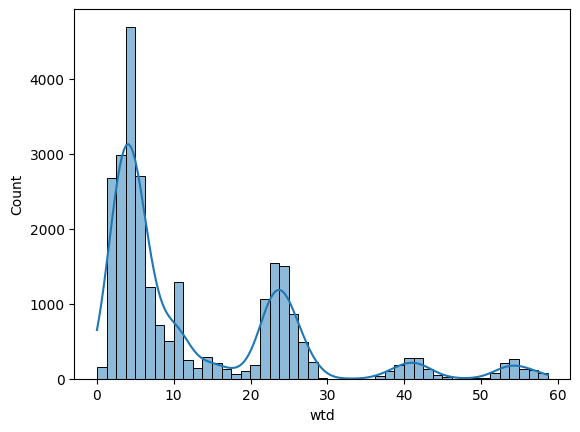

In [14]:
sns.histplot(ds.wtd_df["wtd"], kde=True)

<Axes: ylabel='Count'>

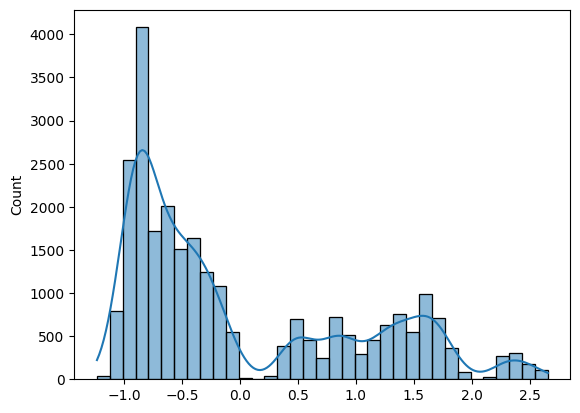

In [23]:
new_var = ds.wtd_df["wtd"]/ds.wtd_df["height"]
new_var_mean = new_var.mean()
new_var_std = new_var.std()
sns.histplot((new_var-new_var_mean)/new_var_std, kde=True)

<Axes: ylabel='Count'>

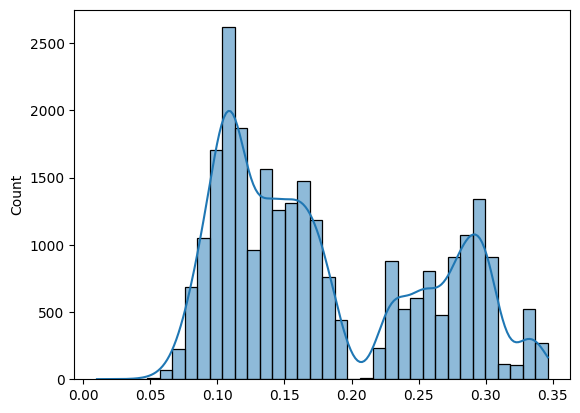

In [26]:
new_var = np.sqrt(ds.wtd_df["wtd"]/ds.wtd_df["height"])
new_var_mean = new_var.mean()
new_var_std = new_var.std()
#new_var = (new_var-new_var_mean)/new_var_std
sns.histplot(new_var, kde=True)

In [31]:
ds.weather_xr.time.dt.year - 2000

<xarray.DataArray 'year' (time: 3410)> Size: 27kB
array([-42, -42, -42, ...,  23,  23,  23])
Coordinates:
  * time         (time) datetime64[ns] 27kB 1958-08-24 1958-08-31 ... 2023-12-24
    spatial_ref  int64 8B 0

<Axes: ylabel='Count'>

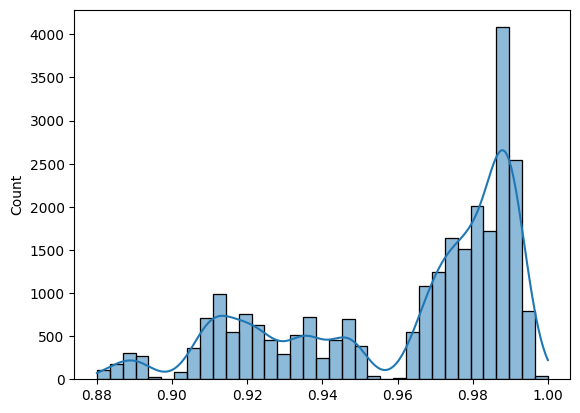

In [28]:
new_var = ds.wtd_df["h"]/ds.wtd_df["height"]
new_var_mean = new_var.mean()
new_var_std = new_var.std()
#new_var = (new_var-new_var_mean)/new_var_std
sns.histplot(new_var, kde=True)

<Axes: xlabel='h', ylabel='Count'>

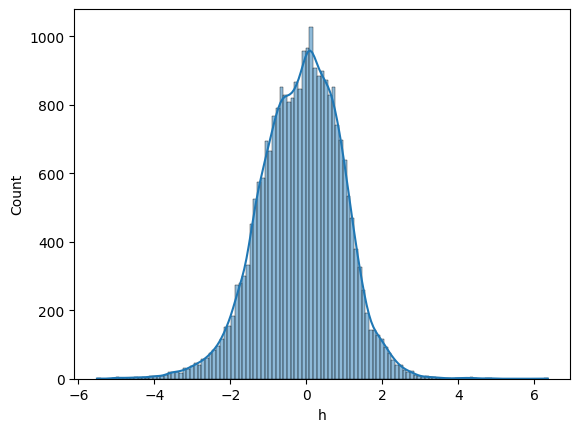

In [12]:
sns.histplot(ds.wtd_df["h"], kde=True)

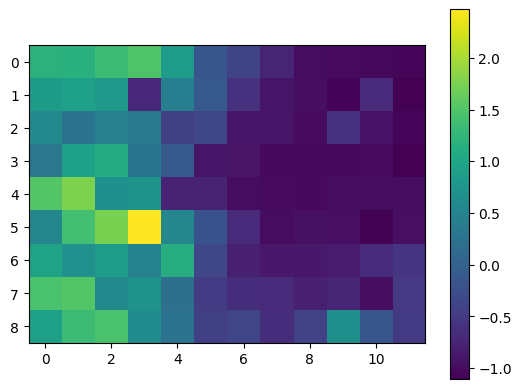

In [13]:
plt.imshow(ds[0][2][0][2,13,:,:])
plt.colorbar()
plt.show()

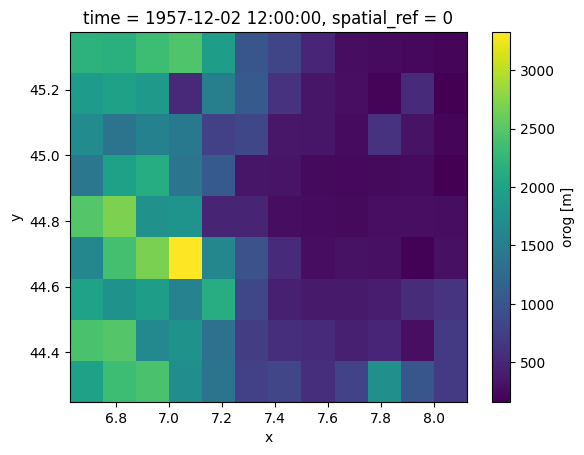

In [14]:
ds.weather_dtm.plot()

In [15]:
from utils import plot
importlib.reload(plot)

<module 'utils.plot' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot.py'>

In [16]:
import geopy.distance

In [17]:
spatial_resolution_meteo =  geopy.distance.geodesic((ds.weather_xr.lat.values[4],
                               ds.weather_xr.lon.values[0]),
                               (ds.weather_xr.lat.values[5],
                                ds.weather_xr.lon.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_meteo, 5))

Y - Resolution in km:  13.89086


In [18]:
spatial_resolution_dtm =  geopy.distance.geodesic((ds.dtm_roi.y.values[4],
                               ds.dtm_roi.x.values[0]),
                               (ds.dtm_roi.y.values[5],
                                ds.dtm_roi.x.values[0])).km
print("Y - Resolution in km: ", round(spatial_resolution_dtm, 5))

Y - Resolution in km:  0.09261


## Dataloader test

In [17]:
from dataloaders import load_dataset_ST_MultiPoint
importlib.reload(load_dataset_ST_MultiPoint)

train_loader, test_loader = load_dataset_ST_MultiPoint.get_dataloader(ds, dict_files)

Traing size: 876 - Start: 2001-03-04 - End: 2017-12-17;
Test size: 315 - Start: 2017-12-24 - End: 2023-12-24


# Model 

In [18]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/CPoint_Sparse/CPoint_Sparse_Transformer_0.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'SparseData_DL', 'run_name': 'SparseData_Transformer', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'ST_MultiPoint', 'piezo_head': True, 'relative_target': False, 'target_lags': [1, 2], 'nan_treshold': 10, 'fill_value': 0, 'normal

In [19]:
from models import models_ST_MultiPoint
importlib.reload(models_ST_MultiPoint)
from models import load_model_ST_MultiPoint
importlib.reload(load_model_ST_MultiPoint)

<module 'models.load_model_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model_ST_MultiPoint.py'>

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [21]:
model, _ = load_model_ST_MultiPoint.load_model(dict_files)

Model: ST_MultiPoint_Net


In [22]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    
model = model.apply(weight_init)

In [23]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of trainable parameters:  34625


In [117]:
1 % 4

1

In [119]:
idx = 0
seq_len = 24
X_0 = []
X_1 = []
X_2 = []
W_0 = []
W_1 = []
Z = []

Y_0 = []
Y_1 = []

for i in range(seq_len):
    
    X_0.append(ds[i][0][0])
    X_1.append(ds[i][0][1])
    X_2.append(ds[i][0][2])
    W_0.append(ds[i][1][0])
    W_1.append(ds[i][1][1])
    Z.append(ds[i][2])
    Y_0.append(ds[i][3][0])
    Y_1.append(ds[i][3][1])
    
X = [torch.stack(X_0, dim = 0),
     torch.stack(X_1, dim = 0),
     torch.stack(X_2, dim = 0)]

W = [torch.stack(W_0, dim = 0),
     torch.stack(W_1, dim = 0)]

Y = [torch.stack(Y_0, dim = 0),
     torch.stack(Y_1, dim = 0)]

Z = torch.stack(Z, dim = 0)

In [25]:
model.train()
prova_out = model(X, W, Z)

In [122]:
len(prova_out.shape)

2

In [121]:
Y[1]

tensor([[False,  True,  True, False,  True,  True,  True, False,  True,  True,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True, False,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True,  True,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True, False,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True, False,
         False, False,  T

In [26]:
ds.lagged_df

h       lat       lon    height   doy_sin  \
date       sensor_id                                                       
2001-03-04 00103510001  0.689230  0.053733 -0.154105 -0.866947  0.882679   
           00104110001       NaN  0.202696  0.094087 -0.951262  0.882679   
           00105110001       NaN  0.446357  0.518426 -1.021212  0.882679   
           00105910001 -0.898284  0.149836  0.808310 -1.018794  0.882679   
           00105910002       NaN  0.233721  0.722698 -1.028230  0.882679   
...                          ...       ...       ...       ...       ...   
2023-12-24 00417910001 -0.626484 -0.123456  0.725215 -0.997253 -0.136906   
           00421510001  0.197800 -0.516018  0.642913 -0.929923 -0.136906   
           00421710001 -0.223473 -0.380864  0.446580 -0.962027 -0.136906   
           00422510001  1.731121 -0.911923  0.364473 -0.777247 -0.136906   
           00425010001  1.111101 -0.751001  0.463569 -0.852743 -0.136906   

                         doy_cos  doy_sin_lag1  doy_cos_lag1  \
date       sensor_id                                           
2001-03-04 00103510001  0.469977      0.819972      0.572404   
           00104110001  0.469977      0.819972      0.572404   
           00105110001  0.469977      0.819972      0.572404   
           00105910001  0.469977      0.819972      0.572404   
           00105910002  0.469977      0.819972      0.572404   
...                          ...           ...           ...   
2023-12-24 00417910001  0.990584     -0.254671      0.967028   
           00421510001  0.990584     -0.254671      0.967028   
           00421710001  0.990584     -0.254671      0.967028   
           00422510001  0.990584     -0.254671      0.967028   
           00425010001  0.990584     -0.254671      0.967028   

                        00103510001_lag1  00104110001_lag1  ...  \
date       sensor_id                                        ...   
2001-03-04 00103510001          0.691232               NaN  ...   
           00104110001          0.691232               NaN  ...   
           00105110001          0.691232               NaN  ...   
           00105910001          0.691232               NaN  ...   
           00105910002          0.691232               NaN  ...   
...                                  ...               ...  ...   
2023-12-24 00417910001          0.662022         -0.340009  ...   
           00421510001          0.662022         -0.340009  ...   
           00421710001          0.662022         -0.340009  ...   
           00422510001          0.662022         -0.340009  ...   
           00425010001          0.662022         -0.340009  ...   

                        00407810001_lag2  00408910001_lag2  00408910002_lag2  \
date       sensor_id                                                           
2001-03-04 00103510001          2.425338          0.723081               NaN   
           00104110001          2.425338          0.723081               NaN   
           00105110001          2.425338          0.723081               NaN   
           00105910001          2.425338          0.723081               NaN   
           00105910002          2.425338          0.723081               NaN   
...                                  ...               ...               ...   
2023-12-24 00417910001          2.399884               NaN          1.354466   
           00421510001          2.399884               NaN          1.354466   
           00421710001          2.399884               NaN          1.354466   
           00422510001          2.399884               NaN          1.354466   
           00425010001          2.399884               NaN          1.354466   

                        00414310002_lag2  00417910001_lag2  00421510001_lag2  \
date       sensor_id                                                           
2001-03-04 00103510001               NaN         -0.617409          0.201254   
           00104110001               NaN         -0.6174

In [27]:
ds.dates

DatetimeIndex(['2001-03-04', '2001-03-11', '2001-03-18', '2001-03-25',
               '2001-04-01', '2001-04-08', '2001-04-15', '2001-04-22',
               '2001-04-29', '2001-05-06',
               ...
               '2023-10-22', '2023-10-29', '2023-11-05', '2023-11-12',
               '2023-11-19', '2023-11-26', '2023-12-03', '2023-12-10',
               '2023-12-17', '2023-12-24'],
              dtype='datetime64[ns]', name='date', length=1191, freq=None)

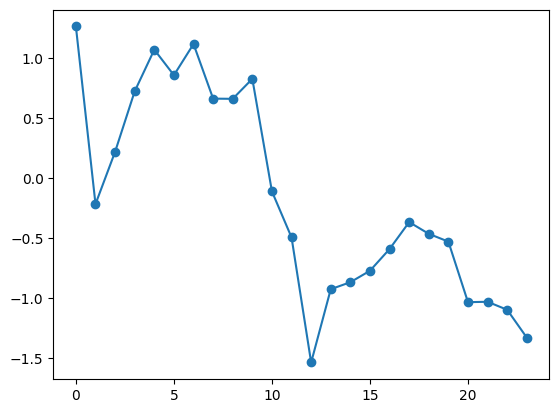

In [28]:
sensor = 0
plt.plot(prova_out[:,sensor].detach().cpu(), marker = "o")

## Grid prediction

In [74]:
from utils import plot_ST_MultiPoint
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

In [ ]:
lat_points = 42
lon_points = 62
z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [ ]:
_ , Y_hat_test, Z_pred = plot_ST_MultiPoint.compute_predictions_MultiPoint(np.datetime64("2023-09-03"),
                                         ds,
                                         model,
                                         device,
                                         Z_grid = z_grid,
                                         get_Z = True)

In [32]:
Y_hat_test.shape

torch.Size([2604])

In [33]:
coords = Z_pred.reshape(lat_points,lon_points,5)
Y_hat_test_grid = Y_hat_test.reshape(lat_points,lon_points)

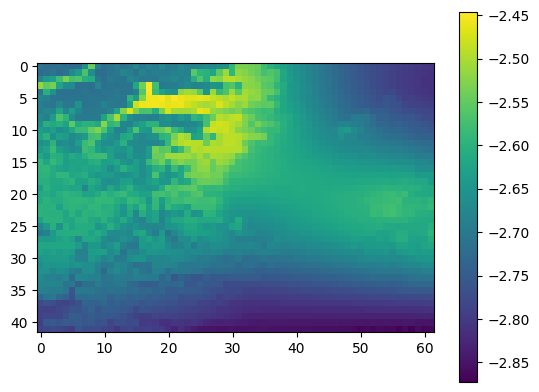

In [34]:
plt.imshow(Y_hat_test_grid)
plt.colorbar()

In [35]:
def compute_predictions_ST_MultiPoint(dataset, model, device, start_date, n_pred, Z_grid = None, iter_pred = False):
    start_date_idx = dataset.dates.get_loc(start_date)
    
    predictions = []
    true = []
    
    if iter_pred is False:
    
        for i in tqdm(range(n_pred)):
            Y , Y_hat = plot.compute_predictions_MultiPoint(dataset.dates[start_date_idx+i],
                                            ds,
                                            model,
                                            device,
                                            Z_grid = Z_grid,
                                            get_Z = False)
            
            predictions.append(Y_hat)
            true.append(Y)
            
    else:
        X = None
        X_deque = [deque(maxlen=len(dataset.target_lags)),
             deque(maxlen=len(dataset.target_lags)),
             deque(maxlen=len(dataset.target_lags))]
        
        for i in tqdm(range(n_pred)):
            Y , Y_hat, Z_pred = plot.compute_predictions_MultiPoint(dataset.dates[start_date_idx+i],
                                            ds,
                                            model,
                                            device,
                                            X = X,
                                            Z_grid = Z_grid,
                                            get_Z = True,
                                            )
            
            X_deque[0].append(Y_hat)
            X_deque[1].append(Z_pred)
            X_deque[2].append(torch.zeros_like(Y_hat).to(torch.bool))
            
            predictions.append(Y_hat)
            true.append(Y)
            
            if i >= len(dataset.target_lags):
                X = [torch.stack(list(X_deque[0])),
                     torch.stack(list(X_deque[1])),
                     torch.stack(list(X_deque[2]))]
            
    true = torch.stack(true, dim = 0)
    predictions = torch.stack(predictions, dim = 0)
        
    return [true, predictions]

In [54]:
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12)

100%|██████████| 12/12 [00:05<00:00,  2.28it/s]


In [55]:
predictions.shape

torch.Size([12, 28])

In [56]:
true, predictions_iter = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12, iter_pred = True)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


In [57]:
predictions_iter.shape

torch.Size([12, 28])

In [58]:
true.shape

torch.Size([12, 28])

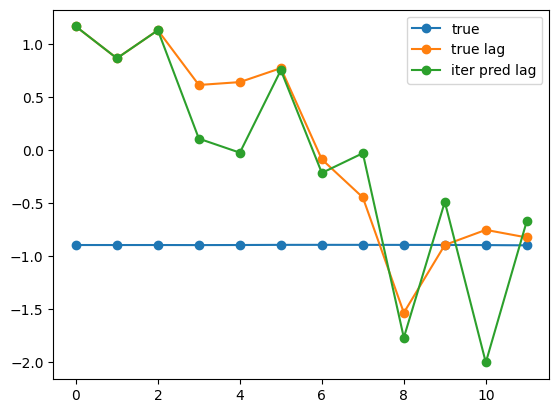

In [40]:
sensor = 3
plt.plot(true[:,sensor].detach().cpu(), marker = "o", label = "true")
plt.plot(predictions[:,sensor].detach().cpu(), marker = "o", label = "true lag")
plt.plot(predictions_iter[:,sensor].detach().cpu(), marker = "o", label = "iter pred lag")
plt.legend()
plt.show()

In [69]:
pred_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions, ds, start_date=np.datetime64("2001-04-01"), n_pred=12, sensor_names=ds.sensor_id_list)
pred_iter_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions_iter, ds, start_date=np.datetime64("2001-04-01"), n_pred=12, sensor_names=ds.sensor_id_list)
true_ds = plot_ST_MultiPoint.build_ds_from_pred(true, ds, start_date=np.datetime64("2001-04-01"), n_pred=12, sensor_names=ds.sensor_id_list)

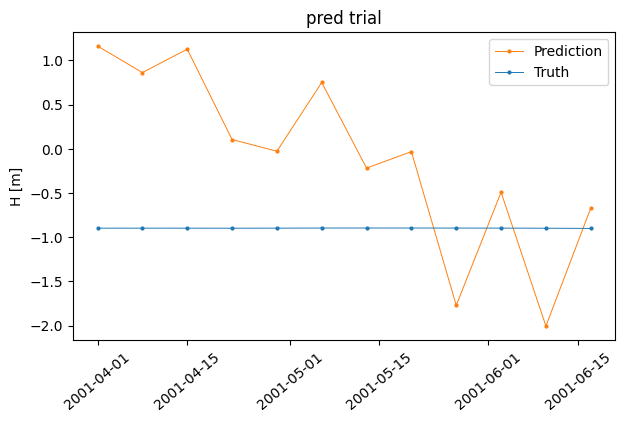

In [72]:
sensor = 3
sensor_id = ds.sensor_id_list[sensor]
plot_ST_MultiPoint.plot_time_series(pred_iter_ds[sensor_id],
                                    true_ds[sensor_id],
                                    title = "pred trial",
                                    print_plot=True)

In [75]:
lat_points = 42
lon_points = 62
Z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [76]:
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12,
                                                Z_grid = Z_grid)

100%|██████████| 12/12 [00:03<00:00,  3.43it/s]


In [78]:
predictions.shape

torch.Size([12, 2604])

In [77]:
predictions_grid = predictions.reshape(12,lat_points,lon_points)

In [79]:
true, predictions_iter = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12, iter_pred = True,
                                                     Z_grid = Z_grid)

100%|██████████| 12/12 [00:04<00:00,  2.95it/s]


In [80]:
predictions_iter_grid = predictions_iter.reshape(12,lat_points,lon_points)

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

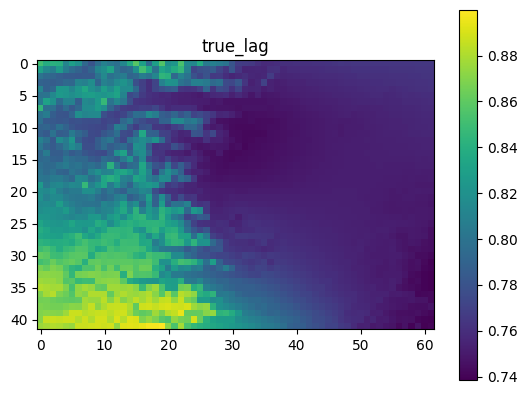

In [47]:
plt.imshow(predictions_grid[5,:,:])
plt.colorbar()
plt.title("true_lag")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

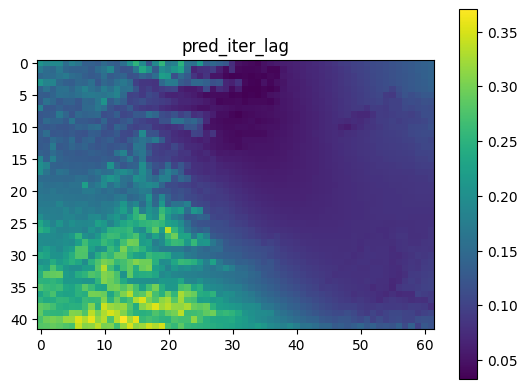

In [48]:
plt.imshow(predictions_iter_grid[5,:,:])
plt.colorbar()
plt.title("pred_iter_lag")
plt.plot

In [81]:
predictions_iter_grid.shape

torch.Size([12, 42, 62])

In [82]:
Z_grid.shape

(2604, 3)

In [84]:
Z_grid_reshape = Z_grid.reshape(lat_points,lon_points,3)
Z_grid_reshape.shape

(42, 62, 3)

In [ ]:
Z_grid_reshape[:,0,0] # lat
Z_grid_reshape[0,:,1] # lon

array([ 1.40201997,  1.32991321,  1.25780645,  1.18569968,  1.11359292,
        1.04148616,  0.96937939,  0.89727263,  0.82516587,  0.7530591 ,
        0.68095234,  0.60884558,  0.53673881,  0.46463205,  0.39252529,
        0.32041852,  0.24831176,  0.176205  ,  0.10409824,  0.03199147,
       -0.04011529, -0.11222205, -0.18432882, -0.25643558, -0.32854234,
       -0.40064911, -0.47275587, -0.54486263, -0.6169694 , -0.68907616,
       -0.76118292, -0.83328969, -0.90539645, -0.97750321, -1.04960997,
       -1.12171674, -1.1938235 , -1.26593026, -1.33803703, -1.41014379,
       -1.48225055, -1.55435732])

In [92]:
#np.datetime64("2001-04-01"), 12
start_date_idx = ds.dates.get_loc(np.datetime64("2001-04-01"))
dates = [ds.dates[start_date_idx+i] for i in range(12)]
dates

[Timestamp('2001-04-01 00:00:00'),
 Timestamp('2001-04-08 00:00:00'),
 Timestamp('2001-04-15 00:00:00'),
 Timestamp('2001-04-22 00:00:00'),
 Timestamp('2001-04-29 00:00:00'),
 Timestamp('2001-05-06 00:00:00'),
 Timestamp('2001-05-13 00:00:00'),
 Timestamp('2001-05-20 00:00:00'),
 Timestamp('2001-05-27 00:00:00'),
 Timestamp('2001-06-03 00:00:00'),
 Timestamp('2001-06-10 00:00:00'),
 Timestamp('2001-06-17 00:00:00')]

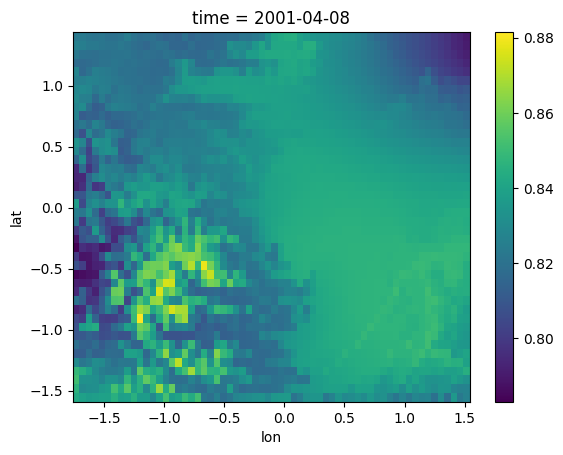

In [96]:
predictions_iter_xr = xarray.DataArray(data = predictions_iter_grid,
                                coords = dict(
                                            lat=("lat", Z_grid_reshape[:,0,0]),
                                            lon=("lon", Z_grid_reshape[0,:,1]),
                                            time=dates),
                                dims = ["time","lat", "lon"]
                                )
predictions_iter_xr[1].plot()

In [100]:
ds.norm_factors["dtm_mean"].values

array(1139.4907, dtype=float32)

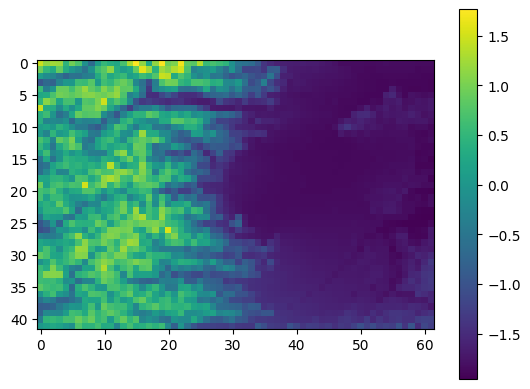

In [103]:
plt.imshow(Z_grid_reshape[:,:,2] - predictions_iter_xr[1])
plt.colorbar()

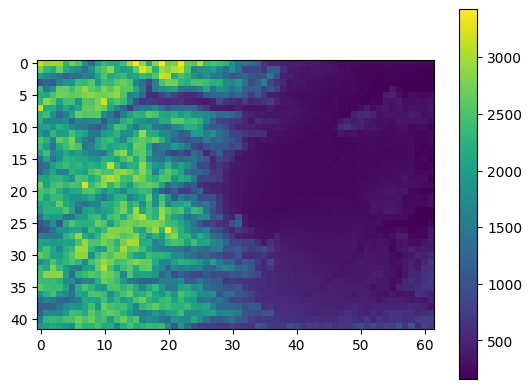

In [102]:
plt.imshow((Z_grid_reshape[:,:,2]*ds.norm_factors["dtm_std"].values) + ds.norm_factors["dtm_mean"].values)
plt.colorbar()

In [108]:
def plot_map(predictions_xr, true_xr,
                 title,
                 x_label = "WTD",
                 vmin = None,
                 vmax = None,
                 save_dir = None, 
                 print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    fig.suptitle(title)
    
    vmin = vmin if vmin is not None else true_xr.min().values
    vmax = vmax if vmax is not None else true_xr.max().values

    predictions_xr.plot(ax = ax[0],
                vmin = vmin,
                vmax = vmax)
    ax[0].set_title(f"Prediction {x_label} [m]")

    true_xr.plot(ax = ax[1],
                vmin = vmin,
                vmax = vmax)
    ax[1].set_title(f"True {x_label} [m]")

    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    if print_plot is True:
        plt.tight_layout()
        
    else:
        return fig 

In [109]:
predictions_iter_xr.min()

<xarray.DataArray ()> Size: 4B
array(-1.1965674, dtype=float32)

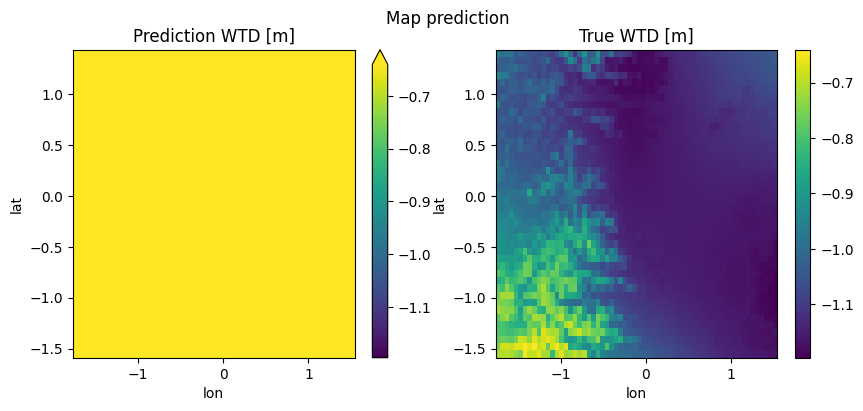

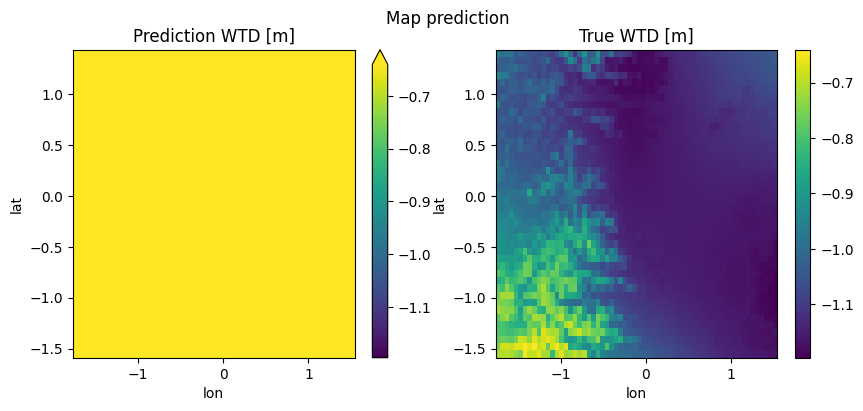

In [ ]:
plot_map(predictions_iter_xr[0],
         predictions_iter_xr[10],
                 title = f"Map prediction",
                 x_label = "WTD",
                 vmin = None,
                 vmax = None,
                 save_dir = None, 
                 print_plot = False)

## Load trained model

In [59]:
model_name_path = "model_SparseData_Transformer_20250717_171819" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

SparseData_Transformer(
  (activation_fn): LeakyReLU(negative_slope=0.01)
  (SparseAutoreg_Module): Spatial_Attention_Block(
    (activation): LeakyReLU(negative_slope=0.01)
    (topo_embeddings): Sequential(
      (0): Linear(in_features=3, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (value_embeddings): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (cb_multihead_att_1): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (norm_linear): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
    )
  )
  (ST_Conditioning_Module): ST_Conditioning_Block(
    (activation): LeakyReLU(negative_slope=0.01)
    (ST_layers): Sequential(
      (0): Li

In [60]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


In [61]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)
Y_hat_test_grid = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

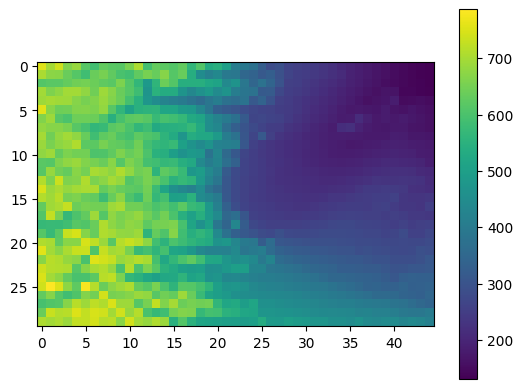

In [66]:
plt.imshow(Y_hat_test_grid[3,:,:])
plt.colorbar()

# Loss

In [147]:
from loss import losses_SparseData
importlib.reload(losses_SparseData)

<module 'loss.losses_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/loss/losses_SparseData.py'>

In [137]:
batch_s = 5
x_batch = torch.stack([ds[i][0] for i in range(batch_s)], dim = 0)
z_batch = torch.stack([ds[i][1] for i in range(batch_s)], dim = 0)
w0_batch = torch.stack([ds[0][2][0] for i in range(batch_s)], dim = 0)
w1_batch = torch.stack([ds[0][2][1] for i in range(batch_s)], dim = 0)
w_batch = [w0_batch, w1_batch]
true_batch = torch.stack([ds[i][-3] for i in range(batch_s)], dim = 0)
xmask_batch = torch.stack([ds[i][-2] for i in range(batch_s)], dim = 0)
ymask_batch = torch.stack([ds[i][-1] for i in range(batch_s)], dim = 0)

In [138]:
model.train()
out_batch = model(x_batch,
                  z_batch,
                  w_batch,
                  xmask_batch,
                       teacher_forcing = True)

In [139]:
norm_factor = [torch.tensor(ds.norm_factors["target_means"]).to(out_batch.device).to(torch.float32),
            torch.tensor(ds.norm_factors["target_stds"]).to(out_batch.device).to(torch.float32)
            ]

In [87]:
out_batch.shape

torch.Size([5, 26, 28])

In [92]:
true_batch.shape

torch.Size([5, 26, 28])

In [155]:
losses_SparseData.loss_masked_h2(out_batch, true_batch, ymask_batch,
            norm_factor)

tensor([[[ 90.5781,  92.5830, 174.8781,  ...,  29.5957,  22.5359,  22.7983],
         [-64.9565, 140.8301, 129.6301,  ..., 140.9766, -96.3849, -89.1852],
         [365.5546, 294.0675, 331.7056,  ..., 175.5725, -87.6100, -76.2506],
         ...,
         [132.6866, 142.8001, 102.6010,  ..., 179.1476, 217.8306, 159.3986],
         [144.0751, 129.7386, 119.3159,  ..., 178.4463, 214.8107, 164.2427],
         [ 94.8056, 176.8314, 163.9642,  ..., 208.4325, 158.4632, 236.5394]],

        [[606.7235, 489.5417, 328.0421,  ..., 177.7885, 223.4379, 154.7892],
         [406.4716, 359.2103, 241.4683,  ..., 133.3777,  28.8863,  31.6063],
         [681.2541, 538.9100, 276.3175,  ...,   3.5021, 166.3419, 149.5751],
         ...,
         [233.0011, 172.5778, 160.3578,  ..., 268.0643, 193.9412, 220.2015],
         [261.3091, 267.8188, 282.5597,  ..., 237.8039, 175.3546, 191.8213],
         [260.9424, 256.3831, 264.4753,  ..., 270.7410, 223.3766, 209.6097]],

        [[405.7957, 393.7622, 336.9928,  ...

tensor(453407.5312, grad_fn=<DivBackward0>)

In [150]:
h2_denorm = losses_SparseData.point_h2((out_batch* norm_factor[1]) + norm_factor[0],
         (true_batch* norm_factor[1]) + norm_factor[0],
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [151]:
h2_norm = losses_SparseData.point_h2(out_batch,
         true_batch,
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [156]:
Y_tstep_avail_mask = (torch.sum(ymask_batch, dim = 1) > 1)
Y_tstep_avail_mask.shape

torch.Size([5, 28])

In [157]:
torch.sum(h2_denorm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(453407.5312, grad_fn=<DivBackward0>)

In [158]:
torch.sum(h2_norm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(1748253.1250, grad_fn=<DivBackward0>)